In [85]:
# %matplotlib
# %matplotlib inline
# %matplotlib notebook

import pandas as pd
import numpy as np
import random
import os
import warnings
from datetime import datetime, timedelta, timezone
warnings.simplefilter("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import math
from copy import deepcopy
from numba_stats import t
import scipy.stats as stats

import gridmeter as gm

from IPython.display import Image, Markdown, display
plt.ion()
plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 300

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

import requests
import re
import io
import time
from pathlib import Path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
df_ls = pd.read_csv("/app/.recurve_cache/NREL/buildings_IL.csv")

# convert datetime column to datetime
df_ls['datetime'] = pd.to_datetime(df_ls['datetime'])

In [88]:
df = pd.read_parquet("/app/.recurve_cache/NREL/buildings_IL_unique.parquet")

In [76]:
data_settings = gm.Data_Settings()

# get month from datetime
df_ls['month'] = df_ls['datetime'].dt.month

df_ls["season"] = df_ls["month"].apply(lambda x: data_settings.SEASON._NUM_DICT[x])

# sum observed for each id and season
df_feature = df_ls.groupby(['id', 'season'])['observed'].sum().reset_index()

# pivot table
df_feature = df_feature.pivot(index='id', columns='season', values='observed').reset_index().set_index("id")
df_feature["total"] = df_feature.sum(axis=1)

df_feature = df_feature[["summer", "winter", "total"]]

# rename columns
df_feature.columns = ["summer_usage", "winter_usage", "annual_usage"]

df_feature = df_feature.reset_index()

file_path = f"/app/applied_data_science/gridmeter/gridmeter/data/features.csv"
df_feature.to_csv(file_path, index=False)

# get size of file in mb
file_size = os.path.getsize(file_path) / (1024 * 1024)
print(file_size)

0.07109260559082031


In [79]:
time_period = "seasonal_hourly_day_of_week"

data_settings = gm.Data_Settings(LOADSHAPE_TYPE="observed", TIME_PERIOD=time_period)
data = gm.Data(data_settings)
data.set_data(time_series_df=df_ls)

ls = data.get_loadshape()

file_path = f"/app/applied_data_science/gridmeter/gridmeter/data/{time_period}_loadshape.csv"
ls.to_csv(file_path)

# get size of file in mb
file_size = os.path.getsize(file_path) / (1024 * 1024)

print(file_size)

10.616388320922852


{1: 'winter',
 2: 'winter',
 3: 'shoulder',
 4: 'shoulder',
 5: 'shoulder',
 6: 'summer',
 7: 'summer',
 8: 'summer',
 9: 'summer',
 10: 'shoulder',
 11: 'winter',
 12: 'winter'}

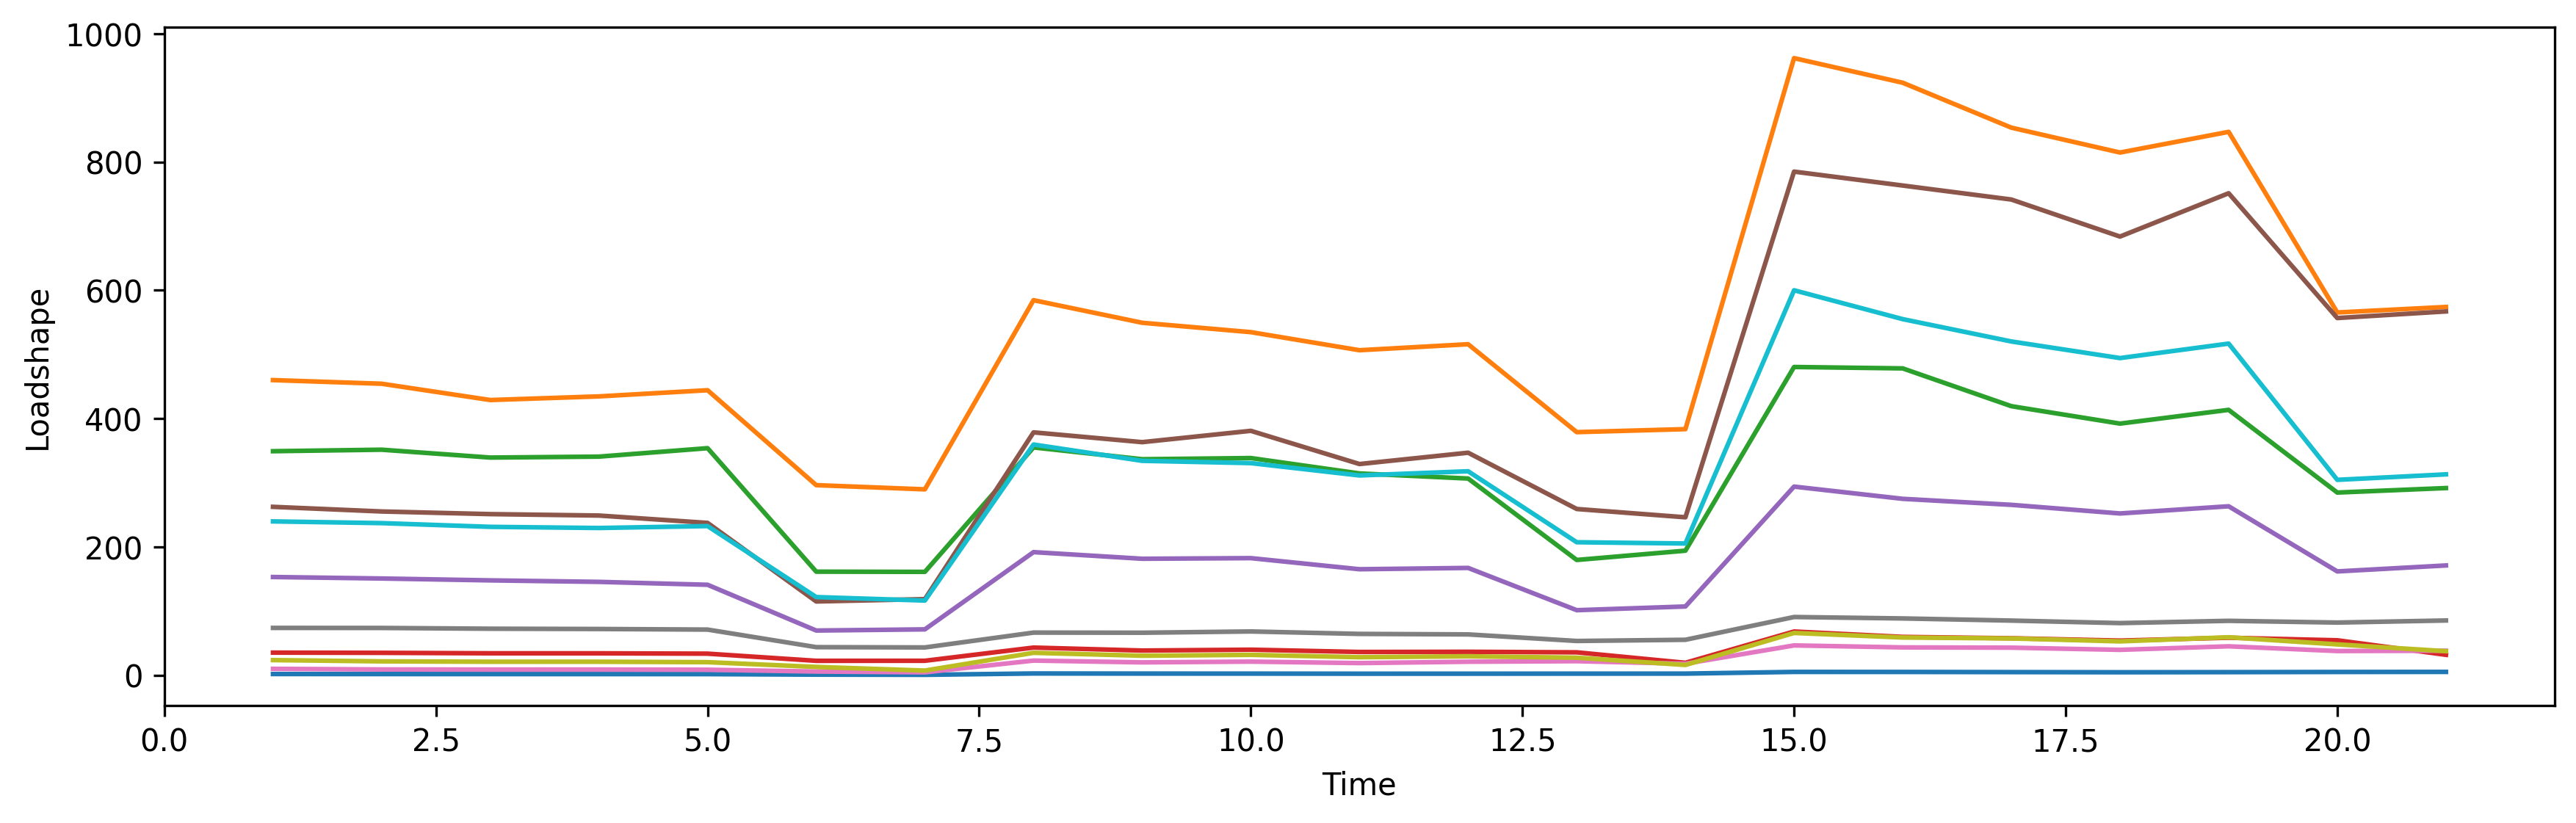

In [40]:
n = 0

ls_plot = ls.iloc[:10]

# plot loadshapes
fig = plt.figure(figsize=(14, 4), dpi=300)
ax = fig.subplots()

for col in ls_plot.T.columns:
    ax.plot(ls_plot.T.index, ls_plot.T[col], label=col)

ax.set_xlabel('Time')
ax.set_ylabel('Loadshape')
# ax.legend()
fig.show()

In [27]:
ids = df_ls['id'].unique()

# randomly sample 100 ids from the list
t_ids = random.sample(list(ids), 100)
df_t = df_ls[df_ls['id'].isin(t_ids)]

# randomly sample 1000 ids from the remaining list
pool_ids = random.sample(list(set(ids) - set(t_ids)), 1000)
df_pool = df_ls[df_ls['id'].isin(pool_ids)]

In [34]:
data_settings

Data_Settings(AGG_TYPE=<AggType.MEAN: 'mean'>, LOADSHAPE_TYPE=<LoadshapeType.OBSERVED: 'observed'>, TIME_PERIOD=<TimePeriod.SEASONAL_HOURLY_DAY_OF_WEEK: 'seasonal_hourly_day_of_week'>, INTERPOLATE_MISSING=True, MIN_DATA_PCT_REQUIRED=0.8, SEASON=Season_Definition(JANUARY='winter', FEBRUARY='winter', MARCH='shoulder', APRIL='shoulder', MAY='shoulder', JUNE='summer', JULY='summer', AUGUST='summer', SEPTEMBER='summer', OCTOBER='shoulder', NOVEMBER='winter', DECEMBER='winter', OPTIONS=['summer', 'shoulder', 'winter']), WEEKDAY_WEEKEND=Weekday_Weekend_Definition(MONDAY='weekday', TUESDAY='weekday', WEDNESDAY='weekday', THURSDAY='weekday', FRIDAY='weekday', SATURDAY='weekend', SUNDAY='weekend', OPTIONS=['weekday', 'weekend']))

In [ ]:
df_ls_t = pd.read_csv("/app/.recurve_cache/clustering/example_dfs/df_ls_t.csv")
df_ls_cp = pd.read_csv("/app/.recurve_cache/clustering/example_dfs/df_ls_cp.csv")

df_ls_t = df_ls_t.rename(columns={"hour": "time", "ls": "loadshape"})
df_ls_cp = df_ls_cp.rename(columns={"hour": "time", "ls": "loadshape"})

data_settings = gm.Data_Settings(AGG_TYPE=None, LOADSHAPE_TYPE=None, TIME_PERIOD=None)

treatment_data = gm.Data(data_settings)
treatment_data.set_data(df_ls_t)

pool_data = gm.Data(data_settings)
pool_data.set_data(df_ls_cp)

In [ ]:
# Test Clustering

clustering_settings = gm.Clustering_Settings(TREATMENT_MATCH_LOSS="MAE", USE_MULTIPROCESSING=True)
clustering = gm.Clustering(clustering_settings)
df_cg, df_t_coeffs = clustering.get_comparison_group(treatment_data, pool_data)
df_cg

In [ ]:
# Test IMM

imm_settings = gm.IMM_Settings()
imm = gm.IMM(imm_settings)
df_cg, df_t_coeffs = imm.get_comparison_group(treatment_data, pool_data)

In [ ]:
imm.get_loadshapes()

In [ ]:
imm.plot_loadshapes()

In [24]:
from __future__ import annotations

import pydantic

# import gridmeter._stratified_sampling.const as _const
from gridmeter._utils.base_settings import BaseSettings

from typing import Optional, Literal

class StratificationColumnSettings(BaseSettings):
    """column name to use for stratification"""
    COLUMN_NAME: str = pydantic.Field()

    """fixed number of bins to use for stratification"""
    N_BINS: int = pydantic.Field(
        default=8, 
        ge=2, 
        validate_default=True,
    )

    """minimum treatment value used to construct bins (used to remove outliers)"""
    MIN_VALUE_ALLOWED: int = pydantic.Field(
        default=3000, 
        ge=0, 
        validate_default=True,
    )

    """maximum treatment value used to construct bins (used to remove outliers)"""
    MAX_VALUE_ALLOWED: int = pydantic.Field(
        default=6000, 
        ge=0, 
        validate_default=True,
    )

    """whether to use fixed width bins or fixed proportion bins"""
    IS_FIXED_WIDTH: bool = pydantic.Field(
        default=False, 
    )

    """column requires equivalence when auto-binning"""
    AUTO_BIN_EQUIVALENCE: bool = Literal["True"]

StratificationColumnSettings(column_name="summer")

StratificationColumnSettings(COLUMN_NAME='summer', N_BINS=8, MIN_VALUE_ALLOWED=3000, MAX_VALUE_ALLOWED=6000, IS_FIXED_WIDTH=False, AUTO_BIN_EQUIVALENCE=typing.Literal['True'])